In [1]:

import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import OrderedDict

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [5]:
dataframe = pd.read_csv(r'E:\Internship\week3.csv');
dataframe

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,...,Deliverable Qty,% Dly Qt to Traded Qty,Volatility,21_day_SMA,34_day_SMA,Trade_Call,14_day_SMA,14_day_STD,14_day_bollinger_upper,14_day_bollinger_lower
0,BPCL,EQ,2017-05-15,733.15,734.65,736.00,723.00,729.00,727.85,728.22,...,289193,34.44,NaN,NaN,NaN,HODL,NaN,NaN,NaN,NaN
1,BPCL,EQ,2017-05-16,727.85,727.00,735.00,723.00,733.25,733.30,729.34,...,282494,32.41,NaN,NaN,NaN,HODL,NaN,NaN,NaN,NaN
2,BPCL,EQ,2017-05-17,733.30,732.90,734.00,723.50,727.05,727.45,727.80,...,537536,47.11,NaN,NaN,NaN,HODL,NaN,NaN,NaN,NaN
3,BPCL,EQ,2017-05-18,727.45,722.20,727.50,711.00,712.60,714.90,717.16,...,351569,33.55,NaN,NaN,NaN,HODL,NaN,NaN,NaN,NaN
4,BPCL,EQ,2017-05-19,714.90,715.25,722.45,700.00,703.50,702.45,709.17,...,407185,38.07,NaN,NaN,NaN,HODL,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,BPCL,EQ,2019-05-07,390.35,388.45,388.45,372.10,380.00,378.85,377.34,...,1364064,18.19,0.059997,362.157143,372.814706,HODL,364.496429,16.120752,396.737932,332.254925
490,BPCL,EQ,2019-05-08,378.85,378.05,383.40,373.10,376.40,379.80,379.30,...,858245,22.58,0.058001,362.947619,372.505882,HODL,365.828571,16.586785,399.002141,332.655002
491,BPCL,EQ,2019-05-09,379.80,379.60,379.60,366.55,367.70,368.05,371.61,...,790374,17.51,0.059885,363.602381,371.675000,HODL,366.517857,16.454314,399.426486,333.609228
492,BPCL,EQ,2019-05-10,368.05,367.05,367.50,359.80,362.45,362.95,361.95,...,868426,21.10,0.053258,363.833333,370.422059,HODL,366.907143,16.288184,399.483511,334.330774


In [6]:
def call(row):
    if row['Close Price'] <= row['14_day_bollinger_lower']: return 'Buy'    
    if row['Close Price'] >= row['14_day_bollinger_upper']: return 'Short'
    if row['Close Price'] == row['14_day_bollinger_upper']: return 'Hold'    
    if row['Close Price'] >  row['14_day_SMA']:             return 'Hold Buy / Liquidate Short'
    if row['Close Price'] <  row['14_day_SMA']:             return 'Hold Short / Liquidate Buy'
    
dataframe['Call'] = dataframe.apply(call, axis=1)
dataframe['Call'].unique()

array([None, 'Hold Buy / Liquidate Short', 'Hold Short / Liquidate Buy',
       'Buy', 'Short'], dtype=object)

In [7]:

scaler = StandardScaler()

X = dataframe.dropna()[['Close Price', '14_day_STD', '14_day_bollinger_upper', '14_day_bollinger_lower']]
y = dataframe.dropna()['Call']    
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

max_features = len(y.unique())
encoder      = LabelEncoder()

In [8]:
classifiers = OrderedDict([
    ( "Nearest Neighbors", KNeighborsClassifier(max_features) ),
    ( "Linear SVM",        SVC(kernel="linear", C=0.025) ),
    ( "RBF SVM",           SVC(gamma=2, C=1) ),
    ( "Gaussian Process",  GaussianProcessClassifier(1.0 * RBF(1.0)) ),
    ( "Decision Tree",     DecisionTreeClassifier(max_depth=5) ),
    ( "Random Forest",     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=max_features) ),
    ( "Neural Net",        MLPClassifier(alpha=1, max_iter=1000) ),
    ( "AdaBoost",          AdaBoostClassifier() ),
    ( "Naive Bayes",       GaussianNB() ),
    ( "QDA",               QuadraticDiscriminantAnalysis() ),
])

In [9]:
scores = {}
for (name, classifier) in classifiers.items():
  classifier.fit(X_train, y_train)
  scores[name] = classifier.score(X_test, y_test)
    
scores = OrderedDict(sorted(scores.items(), key=lambda x: x[1]))
scores

C:\Users\iamakhilesh\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


OrderedDict([('Linear SVM', 0.43137254901960786),
             ('Naive Bayes', 0.5686274509803921),
             ('AdaBoost', 0.6143790849673203),
             ('Decision Tree', 0.7058823529411765),
             ('Random Forest', 0.7254901960784313),
             ('RBF SVM', 0.7843137254901961),
             ('Nearest Neighbors', 0.8235294117647058),
             ('Gaussian Process', 0.8431372549019608),
             ('Neural Net', 0.8627450980392157),
             ('QDA', 0.869281045751634)])

In [14]:
titan = pd.read_csv(r'E:\Internship\Large_Cap\Large_Cap/TITAN.csv');
titan

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,TITAN,EQ,15-May-2017,495.00,489.65,490.00,472.40,486.00,483.65,479.93,3897357,1.870465e+09,52478,1722661,44.20
1,TITAN,EQ,16-May-2017,483.65,486.00,491.00,480.80,490.00,488.30,487.32,1308863,6.378316e+08,33942,563667,43.07
2,TITAN,EQ,17-May-2017,488.30,490.00,490.10,477.30,481.00,481.75,482.25,859054,4.142814e+08,26686,448314,52.19
3,TITAN,EQ,18-May-2017,481.75,479.00,482.60,470.05,470.85,471.65,474.78,811219,3.851526e+08,24621,438716,54.08
4,TITAN,EQ,19-May-2017,471.65,475.00,479.50,460.35,469.65,471.15,469.05,1022479,4.795891e+08,27225,263561,25.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,TITAN,EQ,07-May-2019,1082.85,1097.80,1105.00,1083.00,1090.00,1086.50,1094.54,2605643,2.851972e+09,83154,507973,19.50
492,TITAN,EQ,08-May-2019,1086.50,1090.00,1100.00,1067.85,1096.80,1088.70,1085.83,3336769,3.623149e+09,92788,472241,14.15
493,TITAN,EQ,09-May-2019,1088.70,1100.00,1110.00,1088.70,1103.20,1104.45,1099.15,4362293,4.794807e+09,131781,751092,17.22
494,TITAN,EQ,10-May-2019,1104.45,1108.00,1137.85,1094.30,1129.45,1132.10,1117.09,3032624,3.387712e+09,101440,1044911,34.46


In [16]:
titan['Date'] = pd.to_datetime(titan.Date)
titan

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,TITAN,EQ,2017-05-15,495.00,489.65,490.00,472.40,486.00,483.65,479.93,3897357,1.870465e+09,52478,1722661,44.20
1,TITAN,EQ,2017-05-16,483.65,486.00,491.00,480.80,490.00,488.30,487.32,1308863,6.378316e+08,33942,563667,43.07
2,TITAN,EQ,2017-05-17,488.30,490.00,490.10,477.30,481.00,481.75,482.25,859054,4.142814e+08,26686,448314,52.19
3,TITAN,EQ,2017-05-18,481.75,479.00,482.60,470.05,470.85,471.65,474.78,811219,3.851526e+08,24621,438716,54.08
4,TITAN,EQ,2017-05-19,471.65,475.00,479.50,460.35,469.65,471.15,469.05,1022479,4.795891e+08,27225,263561,25.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,TITAN,EQ,2019-05-07,1082.85,1097.80,1105.00,1083.00,1090.00,1086.50,1094.54,2605643,2.851972e+09,83154,507973,19.50
492,TITAN,EQ,2019-05-08,1086.50,1090.00,1100.00,1067.85,1096.80,1088.70,1085.83,3336769,3.623149e+09,92788,472241,14.15
493,TITAN,EQ,2019-05-09,1088.70,1100.00,1110.00,1088.70,1103.20,1104.45,1099.15,4362293,4.794807e+09,131781,751092,17.22
494,TITAN,EQ,2019-05-10,1104.45,1108.00,1137.85,1094.30,1129.45,1132.10,1117.09,3032624,3.387712e+09,101440,1044911,34.46


In [17]:
titan = titan[ titan.Series == 'EQ' ]
titan.set_index('Date', drop=False, inplace=True)

In [20]:

titan["14_day_SMA"] = titan['Close Price'].rolling(14).mean()
titan["14_day_STD"] = titan['Close Price'].rolling(14).std()
titan["14_day_bollinger_upper"] = titan["14_day_SMA"] + titan["14_day_STD"] * 2
titan["14_day_bollinger_lower"] = titan["14_day_SMA"] - titan["14_day_STD"] * 2

titan   = titan.dropna()  # fit_transform() breaks if NA is present
titan_X = scaler.fit_transform( titan[['Close Price', '14_day_STD', '14_day_bollinger_upper', '14_day_bollinger_lower']] )
titan['Call']      = classifiers["Neural Net"].predict( titan_X )  # using previously trained Neural Network
titan['Call_Code'] = encoder.fit(titan['Call']).transform(titan['Call'])

titan.to_csv('E:\Internship/TITAN.csv');

print( "titan['Call'].unique() = ", titan['Call'].unique() )
titan.head()

C:\Users\iamakhilesh\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\iamakhilesh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\iamakhilesh\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



titan['Call'].unique() =  ['Hold Buy / Liquidate Short' 'Hold Short / Liquidate Buy']


C:\Users\iamakhilesh\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,...,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty,14_day_SMA,14_day_STD,14_day_bollinger_upper,14_day_bollinger_lower,Call,Call_Code
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-01,TITAN,EQ,2017-06-01,474.90,475.95,476.45,465.3,468.60,470.70,469.95,...,3.360497e+08,34175,330045,46.16,474.917857,6.788696,488.495248,461.340466,Hold Buy / Liquidate Short,0
2017-06-02,TITAN,EQ,2017-06-02,470.70,472.70,474.60,467.0,469.90,471.75,471.04,...,2.810508e+08,13922,292897,49.09,474.067857,6.341518,486.750893,461.384821,Hold Buy / Liquidate Short,0
2017-06-05,TITAN,EQ,2017-06-05,471.75,511.00,569.20,505.0,551.50,551.85,543.12,...,1.471861e+10,321166,4407918,16.27,478.607143,21.629448,521.866039,435.348247,Hold Buy / Liquidate Short,0
2017-06-06,TITAN,EQ,2017-06-06,551.85,547.00,547.10,521.4,528.75,527.15,531.44,...,5.231674e+09,149354,2501129,25.41,481.850000,25.239065,532.328129,431.371871,Hold Buy / Liquidate Short,0
2017-06-07,TITAN,EQ,2017-06-07,527.15,528.00,547.00,528.0,536.00,536.20,538.09,...,2.622771e+09,72214,1048839,21.52,486.460714,28.867597,544.195908,428.725521,Hold Buy / Liquidate Short,0


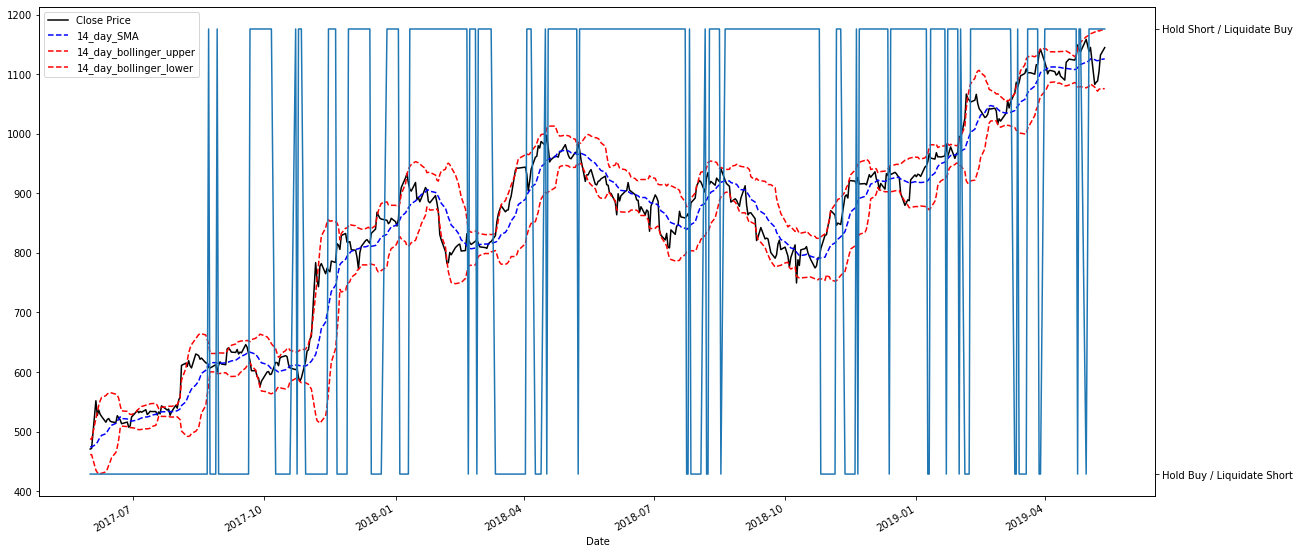

In [21]:

fig = plt.figure(figsize=(20,10))
ax1 = plt.gca()
ax2 = ax1.twinx()


titan.plot(kind='line',x='Date', y='Close Price',             ax=ax1, color='black')
titan.plot(kind='line',x='Date', y='14_day_SMA',              ax=ax1, color='blue', linestyle='--')
titan.plot(kind='line',x='Date', y='14_day_bollinger_upper',  ax=ax1, color='red',  linestyle='--')
titan.plot(kind='line',x='Date', y='14_day_bollinger_lower',  ax=ax1, color='red',  linestyle='--')
ax2.plot( titan['Call'] )

In [29]:

tesla = pd.read_csv(r'E:\Internship\Module 1\week2.csv');

tesla['Date'] = pd.to_datetime(tesla.Date)
tesla


,Date,Close Price,Open Price,High Price,Low Price,Total Traded Quantity,Year,Month,Day_Perc_Change,Trend
0,2019-10-24,299.68,298.97,304.74,290.05,29820000.0,2019,10,NaN,<function trend at 0x000002195E1F4798>
1,2019-10-23,254.68,254.50,256.14,251.35,11220000.0,2019,10,-0.150160,<function trend at 0x000002195E1F4798>
2,2019-10-22,255.58,254.32,258.33,250.85,4630000.0,2019,10,0.003534,<function trend at 0x000002195E1F4798>
3,2019-10-21,253.50,258.33,259.50,250.18,5110000.0,2019,10,-0.008138,<function trend at 0x000002195E1F4798>
4,2019-10-18,256.95,260.70,262.80,255.10,5750000.0,2019,10,0.013609,<function trend at 0x000002195E1F4798>
...,...,...,...,...,...,...,...,...,...,...
498,2017-10-31,331.53,320.23,331.95,320.18,5670000.0,2017,10,0.032546,<function trend at 0x000002195E1F4798>
499,2017-10-30,320.08,319.18,323.78,317.25,4250000.0,2017,10,-0.034537,<function trend at 0x000002195E1F4798>
500,2017-10-27,320.87,319.75,324.59,316.66,6980000.0,2017,10,0.002468,<function trend at 0x000002195E1F4798>
501,2017-10-26,326.17,327.78,330.23,323.20,5020000.0,2017,10,0.016518,<function trend at 0x000002195E1F4798>


In [33]:
#tesla.set_index('Date', drop=False, inplace=True)
tesla['pc_Open_Close'] = ( tesla['Close Price'] - tesla['Open Price'] ) / tesla['Open Price']
tesla['pc_High_Low']   = ( tesla['High Price']  - tesla['Low Price']  ) / tesla['Low Price']
tesla['5_day_mean']    = tesla['Day_Perc_Change'].rolling(5).mean()
tesla['5_day_std']     = tesla['Day_Perc_Change'].rolling(5).std()
tesla.dropna(inplace=True)


tesla['Action'] = np.where(tesla['Close Price'].shift(-1) > tesla['Close Price'], 1, -1 )


tesla.to_csv('E:\Internship\TESLA.csv');
tesla.head()

,Date,Close Price,Open Price,High Price,Low Price,Total Traded Quantity,Year,Month,Day_Perc_Change,Trend,pc_Open_Close,pc_High_Low,5_day_mean,5_day_std,Action
Date,,,,,,,,,,,,,,,
2019-10-17,2019-10-17,261.97,262.50,264.78,260.17,4780000.0,2019,10,0.019537,<function trend at 0x000002195E1F4798>,-0.002019,0.017719,-0.024324,0.071126,-1
2019-10-16,2019-10-16,259.75,257.39,262.10,256.92,6700000.0,2019,10,-0.008474,<function trend at 0x000002195E1F4798>,0.009169,0.020162,0.004014,0.012618,-1
2019-10-15,2019-10-15,257.89,257.70,260.00,254.12,6480000.0,2019,10,-0.007161,<function trend at 0x000002195E1F4798>,0.000737,0.023139,0.001875,0.013589,-1
2019-10-14,2019-10-14,256.96,247.90,258.55,247.13,10230000.0,2019,10,-0.003606,<function trend at 0x000002195E1F4798>,0.036547,0.046210,0.002781,0.012887,-1
2019-10-11,2019-10-11,247.89,247.15,251.08,246.81,8490000.0,2019,10,-0.035297,<function trend at 0x000002195E1F4798>,0.002994,0.017301,-0.007000,0.019485,-1


In [34]:

X = tesla.dropna()[['pc_Open_Close', 'pc_High_Low', '5_day_mean', '5_day_std']]
y = tesla.dropna()['Action']  
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

random_forest = RandomForestClassifier(n_estimators=100, max_features=2)
random_forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:

# Score using the inbult score function
random_forest.fit(X_train,  y_train)
random_forest.score(X_test, y_test)

0.7818181818181819

In [36]:
accuracy_score( y_test, random_forest.predict(X_test), normalize=True )

0.7818181818181819

In [37]:
accuracy_score( y_test, random_forest.predict(X_test), normalize=False ) / len(X_test)


0.7818181818181819

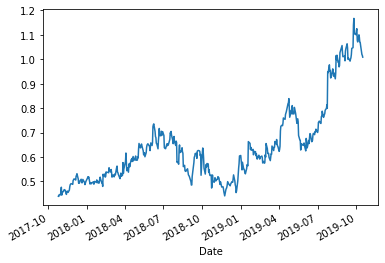

In [40]:
cumulative_returns = ( 1 + (tesla['Close Price'].pct_change() * tesla['Action']) ).dropna().cumprod()
cumulative_returns.plot()